<a href="https://colab.research.google.com/github/jiw3026/DL_NLP_CODE/blob/main/02_RNN_%E1%84%82%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%87%E1%85%A5%E1%84%8B%E1%85%A7%E1%86%BC%E1%84%92%E1%85%AA%E1%84%85%E1%85%B5%E1%84%87%E1%85%B2(%E1%84%92%E1%85%A1%E1%86%AB%E1%84%80%E1%85%AE%E1%86%A8%E1%84%8B%E1%85%A5)_%E1%84%80%E1%85%A1%E1%86%B7%E1%84%89%E1%85%A5%E1%86%BC%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8(%EC%BD%94%EB%93%9C%EC%98%88%EC%8B%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 리뷰 데이터를 활용한 한국어 감정 분석
네이버 영화 리뷰데이터(Naver Sentiment Movie Corpus,NSMC)를 활용해서 감정분석을 수행했습니다.  

패키지 설치

- Konlpy는 KoNLPy란 KoNLPy는 한국어 정보처리를 위한 파이썬 패키지 입니다. 자연어처리(NLP)에서 형태소를 분리(형태소 단위 토크나이징)하는 데이터 전처리가 필요한데 이때 한국어 데이터 전처리를 할 때 많이 사용하는 패키지입니다.

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 59.7 MB/s 


In [ ]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

from konlpy.tag import Okt # komoran, han, kkma

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm

## 데이터 불러오기

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', header=0, delimiter='\t' ,quoting=3)
test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', header=0, delimiter='\t' ,quoting=3)

In [ ]:
display(train.head())
display(test.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
train.shape, test.shape

((150000, 3), (50000, 3))

## 데이터 탐색

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


### 문제1. 학습데이터 중에서 unique한 리뷰의 개수를 확인하세요

In [ ]:
train['document'].nunique()

146182

15만개의 샘플 중 unique한 값 개수가 146182개라는 것은 중복 샘플이 약 4천개정도 존재한다는 말입니다. 중복을 제거하겠습니다

### 문제2. 학습데이터 중 중복된 데이터를 제거하세요

In [ ]:
train.drop_duplicates('document')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


### 문제3. 결측치를 제거하겠습니다 

결측치도 하나 존재합니다. 결측치를 제거하겠습니다

In [ ]:
train[train.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
# 결측치를 제거하고 결과를 확인하세요. 
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


### 문제4. 리뷰는 긍정데이터와 부정데이터로 라벨링 되어 있습니다. 데이터의 분포를 확인하세요

데이터의 분포를 확인해보겠습니다

In [ ]:
train['label'].value_counts()

0    73342
1    72840
Name: label, dtype: int64

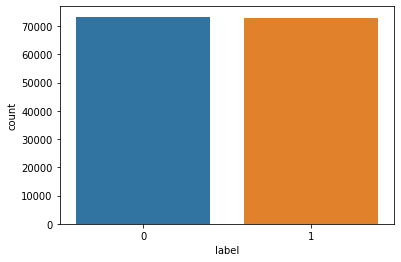

In [ ]:
import seaborn as sns
sns.countplot(
    data = train, 
    x = 'label'
)

레이블이 0인 리뷰가 500개 정도 많지만, 차이가 근소합니다. 

## 데이터 전처리

### 데이터 전처리

### 문제5. 해당 문장에서 한글 및 공백을 제외한 문자를 제거하세요

In [ ]:
review = train['document'][0]

# 한글 및 공백을 제외한 문자 제거 - 정규표현식
review

'아 더빙.. 진짜 짜증나네요 목소리'

In [ ]:
review += 'ㅋㅋㅋㅋㅋㅋ'
print(review)

아 더빙.. 진짜 짜증나네요 목소리ㅋㅋㅋㅋㅋㅋ


In [ ]:
clean_review = re.sub('[^ㄱ-ㅎ가-힣ㅏ-ㅣ\s]', '',review)
clean_review

'아 더빙 진짜 짜증나네요 목소리ㅋㅋㅋㅋㅋㅋ'

주어진 코퍼스(corpus)에서 토큰(token)이라 불리는 단위로 나누는 작업을 토큰화(tokenization)라고 합니다.    
토큰의 단위가 상황에 따라 다르지만, 보통 의미있는 단위로 토큰을 정의합니다.

- 출처 : https://wikidocs.net/21698

### 문제6. 문장을 토크나이징하세요. 

In [ ]:
# 토큰화 - 형태소 단위로 나누기

tokenizer = Okt()
tokens =  tokenizer.morphs(clean_review)# 문장 토큰화
tokens

['아', '더빙', '진짜', '짜증나네요', '목소리', 'ㅋㅋㅋㅋㅋㅋ']

In [ ]:
#@title
tokenizer.morphs("시간떼우는 용으로 보려면 나쁘지 않은 듯")

['시간', '떼우는', '용', '으로', '보려면', '나쁘지', '않은', '듯']

stem = True 옵션을 추가한다면

In [ ]:
# stem = True
tokenizer.morphs("시간떼우는 용으로 보려면 나쁘지 않은 듯", stem = True)

['시간', '떼다', '용', '으로', '보다', '나쁘다', '않다', '듯']

In [ ]:
# 불용어 제거 -> 불용어는 정의하기 나름이다! 
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords = ['아']

res = []
for token in tokens:
    if not token in stopwords:
        res.append(token)
res

['더빙', '진짜', '짜증나네요', '목소리', 'ㅋㅋㅋㅋㅋㅋ']

### 문제7. 문제5-6의 전처리 과정을 하나의 함수로 만드세요.


In [ ]:
# 함수로 만들기
def preprocessing(review, okt, remove_stopwords = False, stop_words = [], test = False):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    
    #####################
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    
    review_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','', review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem = True)

    #####################

    if test:
        print(review_text)
        print(word_review)

    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]

    return word_review

In [ ]:
sample_review = train['document'][0]
sample_review

'아 더빙.. 진짜 짜증나네요 목소리'

In [ ]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
preprocessing(sample_review, Okt(), remove_stopwords = True, stop_words=stop_words, test = True)

아 더빙 진짜 짜증나네요 목소리
['아', '더빙', '진짜', '짜증나다', '목소리']


['더빙', '진짜', '짜증나다', '목소리']

### 문제8. 문제7에서 만든 전처리 함수를 활용하여 학습데이터와 테스트데이터를 정제하세요

In [ ]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_review = []
clean_review_test = []

for review in tqdm(train['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_review.append([])

for review in tqdm(test['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_review_test.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_review_test.append([])

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# # 전처리 데이터 저장하기
# import pickle 

# with open('clean_review.pkl', 'wb') as f:
#     pickle.dump(clean_review, f)

In [ ]:
# # 전처리 데이터 저장하기
# import pickle 

# with open('clean_review_test.pkl', 'wb') as f:
#     pickle.dump(clean_review_test, f)

### 문제9. 전처리한 데이터 불러오기 (pickle파일 불러오기)

파이썬의 pickle(피클) 패키지는 list, dict와 같은 파이썬 객체를 그 형태 그대로 저장하고, 불러올 수 있게끔 하는 패키지​입니다. 

전처리된 리스트를 피클 파일로 저장했습니다. 해당 리스트를 불러오겠습니다



In [ ]:
!gdown --id 1gQ2-j4ZSSJBEWsEgPONbUytxM7NIzMRr # train 
!gdown --id 10RWF87bsIEawuvQfFR22UfdmQxyuf5lu # test

In [ ]:
# 전처리 데이터 불러오기 
import pickle

# clean_review 로 불러오기 
with open('/content/clean_review.pkl', 'rb') as f : 
    clean_review = pickle.load(f)

# clean_review_test 로 불러오기 
with open('/content/clean_review_test.pkl', 'rb') as f : 
    clean_review_test = pickle.load(f)

In [ ]:
clean_review[:3]

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [ ]:
print(len(clean_review))
print(len(clean_review_test))

146182
50000


#### 인코딩 

텍스트를 정수로 바꾸는 것을 인코딩이라고 합니다.   
자주 사용되는 인코딩 방법은 단어를 빈도순으로 정렬하고, 많이 등장한 단어부터 차례대로 숫자를 부여하는 방법입니다. 

케라스의 fit_on_texts() 함수를 사용하여, 단어 인덱스 딕셔너리를 생성하겠습니다. 

### 문제10. 단어 인덱스를 생성하세요

In [ ]:
tokenizer = Tokenizer() # 토큰화 함수 지정

# 단어 인덱스 구축
tokenizer.fit_on_texts(clean_review)

In [ ]:
word_vocab = tokenizer.word_index # 딕셔너리 형태
print("전체 단어 개수: ", len(word_vocab)) # 전체 단어 개수 확인

전체 단어 개수:  43756


In [ ]:
print(word_vocab)

{'영화': 1, '보다': 2, '하다': 3, '에': 4, '을': 5, '도': 6, '를': 7, '없다': 8, '이다': 9, '있다': 10, '좋다': 11, '너무': 12, '다': 13, '정말': 14, '되다': 15, '재밌다': 16, '적': 17, '만': 18, '같다': 19, '진짜': 20, '으로': 21, '로': 22, '아니다': 23, '않다': 24, '점': 25, '에서': 26, '만들다': 27, '과': 28, '나오다': 29, '연기': 30, '평점': 31, '내': 32, '최고': 33, '그': 34, '나': 35, '안': 36, '인': 37, '스토리': 38, '생각': 39, '못': 40, '왜': 41, '드라마': 42, '게': 43, '감동': 44, '사람': 45, '보고': 46, '이렇다': 47, '말': 48, '고': 49, '아깝다': 50, '더': 51, '배우': 52, '때': 53, 'ㅋㅋ': 54, '와': 55, '감독': 56, '거': 57, '그냥': 58, '재미있다': 59, '요': 60, '재미': 61, '시간': 62, '내용': 63, '뭐': 64, '까지': 65, '중': 66, '주다': 67, '좀': 68, '자다': 69, '하고': 70, '지루하다': 71, '재미없다': 72, '쓰레기': 73, '네': 74, '모르다': 75, '가다': 76, '들다': 77, '그렇다': 78, '싶다': 79, '지': 80, '작품': 81, '사랑': 82, '알다': 83, '하나': 84, '다시': 85, '마지막': 86, '볼': 87, '잘': 88, '이건': 89, '정도': 90, '저': 91, '완전': 92, '오다': 93, 'ㅋ': 94, 'ㅠㅠ': 95, '많다': 96, '처음': 97, 'ㅋㅋㅋ': 98, '장면': 99, '액션': 100, '주인공': 101, '이렇게': 102

### 문제 11. 각 문장을 정수로 인코딩하세요

In [ ]:
X_train = tokenizer.texts_to_sequences(clean_review) # 문자열 -> 인덱스 리스트

In [ ]:
clean_review[:3]

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [ ]:
X_train[:3]

[[460, 20, 265, 663],
 [937, 463, 46, 607, 1, 219, 1453, 30, 965, 679, 24],
 [393, 2448, 25019, 2319, 5675, 2, 227, 13]]

이제 각 문자열을 맵핑하겠습니다. 

맵핑 결과, 각 문장의 단어들이 정수로 인코딩된 것을 확인할 수 있습니다. 

### 문제12. 라벨링 데이터를 y_train 데이터로 분리합니다

In [ ]:
# 각 리뷰의 감정을 넘파이 배열로 만듭니다
y_train = np.array(train['label'])

In [ ]:
X_train[0], y_train[0]

([460, 20, 265, 663], 0)

In [ ]:
len(X_train), len(y_train)

(146182, 146182)

#### 추가 전처리

단어가 43,000개가 넘습니다. 빈도수가 낮은 단어들을 모델링에서 제외하겠습니다. 

### 문제 13. 빈도수가 낮은 단어의 개수 확인하기

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %d번 이하인 희귀 단어의 수: %d'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43756
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.619800713045066
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.747004193603733


### 문제14. 단어집합의 크기 제한하기 

등장 횟수가 2번 이하인 단어들이 딕셔너리의 절반이상이지만, 전체 등장 횟수는 2%도 되지 않습니다.   
등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19420


In [ ]:
# 단어집합의 최대 크기를 제한해서 인덱싱합니다. 

tokenizer = Tokenizer(vocab_size) # 단어 집합의 최대 크기 제한 

tokenizer.fit_on_texts(clean_review)
X_train = tokenizer.texts_to_sequences(clean_review)

word_vocab = tokenizer.word_index # 딕셔너리 형태
print("전체 단어 개수: ", tokenizer.num_words) # 전체 단어 개수 확인

전체 단어 개수:  19420


In [ ]:
len(X_train), len(y_train)

(146182, 146182)

### 문제15. 결측치 제거하기

이때, 빈도수가 낮은 단어로만 구성된 리뷰들은 null값이 되었을 수 있습니다. 해당 리뷰들을 제거하겠습니다

In [ ]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 찾으세요. 
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

print(len(drop_train))

1033


In [ ]:
# 빈 샘플들을 제거하세요. X와 y 모두 제거합니다. 
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
print(len(X_train), len(y_train))

145149 145149


### 패딩 
- 서로 다른 길이의 샘플들을 동일한 길이로 맞춰주기

### 문제 16. 최대 문장길이와 평균 문장길이를 확인하세요

In [ ]:
t_len = np.array([len(review) for review in X_train])

max(t_len), t_len.mean()

(69, 11.599294518046973)

문장 길이의 분포를 확인해보겠습니다.

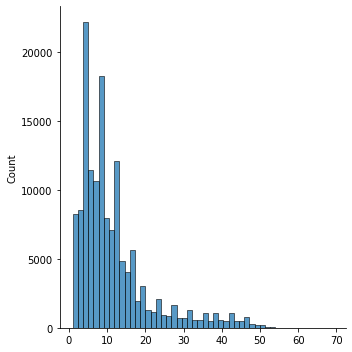

In [ ]:
sns.displot(t_len, bins=50)

In [ ]:
# 문장 길이 40이하면 96.6% 의 문장들이 커버되는 것을 확인 
sum(np.where(t_len<30, 1, 0))/len(t_len)

0.9273229577882038

### 문제17. 문장 최대 길이를 설정하고, 패딩으로 문장 길이를 맞춰주겠습니다. 

In [ ]:
MAX_SEQUENCE_LENGTH = 30 # 문장 최대 길이

# 문장의 길이가 MAX_SEQUENCE_LENGTH 단어가 넘어가면 자르고, 모자르면 0으로 채워 넣는다.
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

print('Shape of input data tensor:', X_train.shape) # 리뷰 데이터의 형태 확인
print('Shape of label tensor:', y_train.shape) # 감정 데이터 형태 확인

Shape of input data tensor: (145149, 30)
Shape of label tensor: (145149,)


In [ ]:
X_train

array([[ 460,   20,  265, ...,    0,    0,    0],
       [ 937,  463,   46, ...,    0,    0,    0],
       [ 393, 2448, 2319, ...,    0,    0,    0],
       ...,
       [  43,   64,   60, ...,    0,    0,    0],
       [1043,    1, 2269, ...,    0,    0,    0],
       [ 201,    1, 1818, ...,    0,    0,    0]], dtype=int32)

##테스트 데이터 전처리

### 문제18. 테스트 데이터셋에도 동일한 전처리를 적용합니다. 
- train 데이터와 동일한 tokenizer로 test 데이터 문장을 인덱싱합니다. 
- train 데이터와 동일한 문장길이로 패딩해줍니다. 


In [ ]:
# 테스트 데이터셋에도 똑같이 적용
text_sequences_test = tokenizer.texts_to_sequences(clean_review_test)  # 인덱싱
X_test = pad_sequences(text_sequences_test, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')  # 패딩

In [ ]:
y_test = np.array(test['label']) # 각 리뷰의 감정을 넘파이 배열로 만든다.

print('Shape of input data tensor:', X_test.shape) # 리뷰 데이터의 형태 확인
print('Shape of label tensor:', y_test.shape) # 감정 데이터 형태 확인

Shape of input data tensor: (50000, 30)
Shape of label tensor: (50000,)


## 모델 구축

### 문제19. LSTM 모델을 사용해서 분류 모델을 생성합니다. 
- 아래 모델 구조를 참고하여 모델을 생성해보세요. 
- optimizer는 adam
- loss는 binary_crossentropy
- metrics는 accuracy로 설정합니다. 

In [ ]:
np.max(np.max(X_test, axis=1))

19418

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

model = Sequential()

model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation = 'sigmoid'))

# 단, 손실 함수(loss function)를 설정할 때 이진 분류에 관한 문제라는 것에 유의하세요.
# 에폭마다 정확도를 보기 위해 accuracy 적용

print(model.summary()) #모델 아키텍처 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1942000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,059,377
Trainable params: 2,059,377
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['acc'])

tf.keras.layers.Embedding(input_dim, output_dim) : 들어올문장을 단어 임베딩하는 레이어
- input_dim : 들어올 단어의 개수
- output_dim : 결과로 나올 임베딩 벡터의 크기 (차원)

In [ ]:
input = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(input.shape)

embedding = tf.keras.layers.Embedding(input_dim = 10, output_dim = 9)
output = embedding(input)

print(output)

(3, 3)
tf.Tensor(
[[[-0.03582833 -0.00064586 -0.02831572 -0.02891331 -0.00892314
   -0.02823299  0.0232727   0.02583325  0.00345961]
  [-0.03686552  0.03070655 -0.02215509 -0.00165905  0.03808233
    0.00815659  0.04282149 -0.02563446 -0.03635837]
  [ 0.02116177 -0.02999417 -0.01337718 -0.0126024   0.04109495
   -0.04132881  0.00244131 -0.00372738 -0.01721181]]

 [[-0.01034907  0.01608841  0.02426416 -0.02402679 -0.01677046
   -0.01465499 -0.0105283   0.03825023  0.0107168 ]
  [-0.03796586  0.03578926 -0.01053911  0.03747786  0.02224903
    0.01553952  0.03898958  0.02311749 -0.02181987]
  [ 0.01185509 -0.00922873  0.02039823 -0.04482697 -0.02041317
    0.00070679 -0.03332175  0.03946498  0.02569591]]

 [[-0.00158047 -0.04244192 -0.00243245 -0.02146571  0.01416248
   -0.02004886 -0.00427962 -0.04659069 -0.00393983]
  [ 0.0142794  -0.00111974  0.0401425  -0.0175771   0.01582292
    0.04489687 -0.03012289  0.00673813  0.00505446]
  [-0.03960606  0.01591298 -0.01895174 -0.0138659   0.0268

## 모델 학습

### 문제20. 모델을 학습합니다. 
- 학습 시 가장 성능이 좋은 모델은 'h5'형식으로 저장하세요. 
- validation loss가 3회 이상 나아지지 않는다면 epoch을 일찍 종료하세요. 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

EPOCHS = 5

mc = ModelCheckpoint(filepath = 'best_model.h5', verbose=1, save_best_only = True)

history = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = 64, validation_split = 0.2, callbacks=[mc])

Epoch 1/5
1811/1815 [============================>.] - ETA: 0s - loss: 0.3217 - acc: 0.8618
Epoch 1: val_loss improved from inf to 0.34813, saving model to best_model.h5
1815/1815 [==============================] - 26s 14ms/step - loss: 0.3216 - acc: 0.8618 - val_loss: 0.3481 - val_acc: 0.8470
Epoch 2/5
1813/1815 [============================>.] - ETA: 0s - loss: 0.2709 - acc: 0.8866
Epoch 2: val_loss did not improve from 0.34813
1815/1815 [==============================] - 16s 9ms/step - loss: 0.2708 - acc: 0.8866 - val_loss: 0.3553 - val_acc: 0.8545
Epoch 3/5
1809/1815 [============================>.] - ETA: 0s - loss: 0.2296 - acc: 0.9062
Epoch 3: val_loss did not improve from 0.34813
1815/1815 [==============================] - 15s 8ms/step - loss: 0.2297 - acc: 0.9062 - val_loss: 0.4009 - val_acc: 0.8497
Epoch 4/5
1810/1815 [============================>.] - ETA: 0s - loss: 0.1908 - acc: 0.9244
Epoch 4: val_loss did not improve from 0.34813
1815/1815 [=============================

### 문제21. 학습과정에서의 정확도와 loss 히스토리를 시각화하세요

In [ ]:
history.history

{'acc': [0.8617711067199707,
  0.8865732550621033,
  0.9062341451644897,
  0.924362063407898,
  0.9377534985542297],
 'loss': [0.3216138780117035,
  0.2708471119403839,
  0.22968004643917084,
  0.1908216029405594,
  0.15903200209140778],
 'val_acc': [0.8469858765602112,
  0.8544608950614929,
  0.8497416377067566,
  0.8471236824989319,
  0.8409920930862427],
 'val_loss': [0.348131388425827,
  0.3552585244178772,
  0.40087905526161194,
  0.42464393377304077,
  0.4726306200027466]}

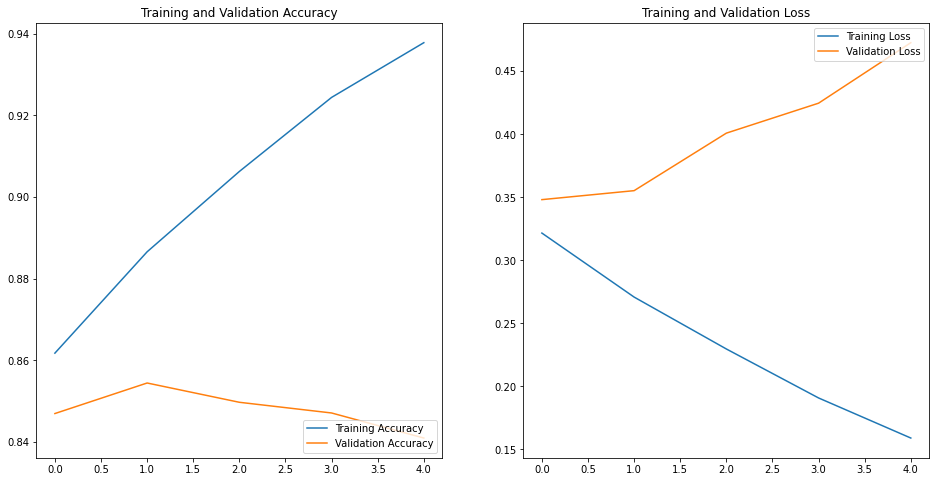

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

# early stopping epoch 
epochs_range = history.epoch

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 모델 검증

### 문제22. 학습한 모델을 불러오세요

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/best_model.h5')

In [ ]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1563/1563 [==============================] - 6s 4ms/step - loss: 0.3610 - acc: 0.8394

 테스트 정확도: 0.8394


### 문제23. 임의의 텍스트를 학습데이터와 동일하게 전처리하고, 긍정/부정을 확률을 출력하는 함수를 만드세요. 

In [ ]:
import re 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from konlpy.tag import Okt 

okt = Okt()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_review) # 단어 인덱스 구축

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

max_len = 30


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 핵노잼ㅋㅋ')

87.70% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('또 보고 싶다')


58.01% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')


53.33% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?')

85.35% 확률로 부정 리뷰입니다.



### 참고 코드

- https://github.com/reniew/NSMC_Sentimental-Analysis/blob/master/notebook/NSMC_Preprocessing.ipynb  

- https://wikidocs.net/44249